In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.5 MB/s eta 0:00:00


In [ ]:
# import statements

import pandas as pd
import seaborn as sns
import matplotlib as plt
import nltk
import nltk.corpus
import re
import numpy as np
import pickle

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

## Feature engineering

In [ ]:
pet_dataset = pd.read_csv('petdata_wo_sample.csv')

<ipython-input-31-f8ffd5a3bbb7>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  pet_dataset = pd.read_csv('/content/drive/MyDrive/Thesis/petdata_wo_sample.csv')


In [ ]:
pet_dataset

,Unnamed: 0,pet,age,gender,color,size,description,pid,photos,adopted,description_words,word_count
0,0,Cat,Adult,Male,Brown_Chocolate,Small,For further information please visit our websi...,41085682,1,Adopted,"['For', 'further', 'information', 'please', 'v...",643
1,1,Cat,Young,Male,Unknown,Medium,Bart is a sweet and joyful boy who loves to be...,42779556,2,Adopted,"['Bart', 'is', 'a', 'sweet', 'and', 'joyful', ...",1975
2,2,Dog,Adult,Female,Other,Medium,Wake up every morning to someone who truly L?V...,40922487,5,Adopted,"['Wake', 'up', 'every', 'morning', 'to', 'some...",1963
3,3,Dog,Baby,Female,Other,Large,Nala is a 9 month old female mix. She is guess...,41787973,6,Adopted,"['Nala', 'is', 'a', '9', 'month', 'old', 'fema...",1558
4,4,Cat,Baby,Female,Other,Medium,Yuki is a social butterfly with people and wit...,42801248,1,Adopted,"['Yuki', 'is', 'a', 'social', 'butterfly', 'wi...",809
...,...,...,...,...,...,...,...,...,...,...,...,...
221176,221326,Dog,Adult,Male,Unknown,Medium,"Woof! It's me Moose, a 2 year old Border Colli...",42312550,3,Unadopted,"['Woof', '!', 'It', ""'s"", 'me', 'Moose', ',', ...",3610
221177,221327,Dog,Adult,Male,Unknown,Medium,"Hi there! My name is Zagnut, but my foster mom...",41380802,5,Unadopted,"['Hi', 'there', '!', 'My', 'name', 'is', 'Zagn...",3628
221178,221328,Cat,Young,Female,Unknown,Medium,Please contact Tia (tkocianic@yahoo.com) for m...,39027997,3,Unadopted,"['Please', 'contact', 'Tia', '(', 'tkocianic',...",3621
221179,221329,Dog,Adult,Female,Unknown,Medium,Hello world! My name is Tassels and I am excit...,42083623,3,Unadopted,"['Hello', 'world', '!', 'My', 'name', 'is', 'T...",3596


## Description cleaner

In [ ]:
# code retrieved from: https://monkeylearn.com/blog/text-cleaning/
# making all texts lowercase

pet_dataset['description'] = pet_dataset['description'].str.lower()


In [ ]:
# code retrieved from: https://monkeylearn.com/blog/text-cleaning/
# removing all links

pet_dataset['description'] = pet_dataset['description'].str.replace(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", regex=True)

In [ ]:
# code retrieved from: https://monkeylearn.com/blog/text-cleaning/
# removing stopwords

nltk.download('stopwords')

stop = stopwords.words('english')

def remove_stopwords(text):
    if pd.isna(text):
        return ""
    return ' '.join([word for word in str(text).split() if word not in stop])

pet_dataset['description'] = pet_dataset['description'].apply(remove_stopwords)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# code retrieved from: https://www.dataquest.io/blog/how-to-clean-and-prepare-your-data-for-analysis/
# lemmatizing the texts

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if pd.isna(text):
        return ""
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

pet_dataset['description'] = pet_dataset['description'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
pet_dataset

,Unnamed: 0,pet,age,gender,color,size,description,pid,photos,adopted,description_words,word_count
0,0,Cat,Adult,Male,Brown_Chocolate,Small,information please visit website wwwhumanesoci...,41085682,1,Adopted,"['For', 'further', 'information', 'please', 'v...",643
1,1,Cat,Young,Male,Unknown,Medium,bart sweet joyful boy love human companion isn...,42779556,2,Adopted,"['Bart', 'is', 'a', 'sweet', 'and', 'joyful', ...",1975
2,2,Dog,Adult,Female,Other,Medium,wake every morning someone truly lf need dog l...,40922487,5,Adopted,"['Wake', 'up', 'every', 'morning', 'to', 'some...",1963
3,3,Dog,Baby,Female,Other,Large,nala 9 month old female mix guessing part germ...,41787973,6,Adopted,"['Nala', 'is', 'a', '9', 'month', 'old', 'fema...",1558
4,4,Cat,Baby,Female,Other,Medium,yuki social butterfly people cat shell well ho...,42801248,1,Adopted,"['Yuki', 'is', 'a', 'social', 'butterfly', 'wi...",809
...,...,...,...,...,...,...,...,...,...,...,...,...
221176,221326,Dog,Adult,Male,Unknown,Medium,woof moose 2 year old border collie available ...,42312550,3,Unadopted,"['Woof', '!', 'It', ""'s"", 'me', 'Moose', ',', ...",3610
221177,221327,Dog,Adult,Male,Unknown,Medium,hi name zagnut foster mom call ziggy say im wa...,41380802,5,Unadopted,"['Hi', 'there', '!', 'My', 'name', 'is', 'Zagn...",3628
221178,221328,Cat,Young,Female,Unknown,Medium,please contact tia tkocianicyahoocom informati...,39027997,3,Unadopted,"['Please', 'contact', 'Tia', '(', 'tkocianic',...",3621
221179,221329,Dog,Adult,Female,Unknown,Medium,hello world name tassel excited get new life s...,42083623,3,Unadopted,"['Hello', 'world', '!', 'My', 'name', 'is', 'T...",3596


In [ ]:
pet_dataset = pet_dataset.drop(columns=['Unnamed: 0', 'description_words', 'word_count'])

pet_dataset.reset_index(drop=True, inplace=True)

In [ ]:
pet_dataset.set_index('pid', inplace=True)

In [ ]:
pet_dataset.reset_index(inplace=True)

In [ ]:
pet_dataset

,pid,pet,age,gender,color,size,description,photos,adopted
0,41085682,Cat,Adult,Male,Brown_Chocolate,Small,information please visit website wwwhumanesoci...,1,Adopted
1,42779556,Cat,Young,Male,Unknown,Medium,bart sweet joyful boy love human companion isn...,2,Adopted
2,40922487,Dog,Adult,Female,Other,Medium,wake every morning someone truly lf need dog l...,5,Adopted
3,41787973,Dog,Baby,Female,Other,Large,nala 9 month old female mix guessing part germ...,6,Adopted
4,42801248,Cat,Baby,Female,Other,Medium,yuki social butterfly people cat shell well ho...,1,Adopted
...,...,...,...,...,...,...,...,...,...
221176,42312550,Dog,Adult,Male,Unknown,Medium,woof moose 2 year old border collie available ...,3,Unadopted
221177,41380802,Dog,Adult,Male,Unknown,Medium,hi name zagnut foster mom call ziggy say im wa...,5,Unadopted
221178,39027997,Cat,Young,Female,Unknown,Medium,please contact tia tkocianicyahoocom informati...,3,Unadopted
221179,42083623,Dog,Adult,Female,Unknown,Medium,hello world name tassel excited get new life s...,3,Unadopted


In [ ]:
pet_dataset.to_csv('pet_feateng1.csv')

In [ ]:
pet_dataset = pd.read_csv('pet_feateng1.csv')

<ipython-input-2-0d78eb04342d>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pet_dataset = pd.read_csv('/content/drive/MyDrive/Thesis/pet_feateng1.csv')


## Doc2Vec + CatBoost

In [ ]:
# code retrieved from: https://stackoverflow.com/questions/45125798/how-to-use-taggeddocument-in-gensim & https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.Doc2Vec

nltk.download('punkt')

documents = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(pet_dataset['description'])]

model = Doc2Vec(vector_size=100, seed=555)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)


model.save("doc2vec.model")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


KeyboardInterrupt: 

In [ ]:
# vectorizing the document embeddings
vectors = [model.dv[str(i)] for i in range(len(pet_dataset['description']))]

In [ ]:
# converting the vectors into a dataframe
vector_df = pd.DataFrame(vectors)
vector_df.columns = [f'vector_{i}' for i in range(vector_df.shape[1])]

In [ ]:
# concatenate the original features and the vectors
full_dataset = pd.concat([pet_dataset.reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)


In [ ]:
full_dataset.to_csv('doc2vec-dataset.csv')

In [ ]:
full_dataset = pd.read_csv('doc2vec-dataset.csv')

<ipython-input-4-971d91185b71>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataset = pd.read_csv('/content/drive/MyDrive/Thesis/doc2vec-dataset.csv')


In [ ]:
full_dataset

,Unnamed: 0,pid,pet,age,gender,color,size,description,photos,adopted,...,vector_90,vector_91,vector_92,vector_93,vector_94,vector_95,vector_96,vector_97,vector_98,vector_99
0,0,41085682,Cat,Adult,Male,Brown_Chocolate,Small,information please visit website wwwhumanesoci...,1,Adopted,...,0.146595,0.016195,0.138211,0.173952,-0.049820,0.143019,0.086237,0.024942,-0.178834,0.294201
1,1,42779556,Cat,Young,Male,Unknown,Medium,bart sweet joyful boy love human companion isn...,2,Adopted,...,0.419164,0.030853,-0.181370,0.142611,0.205603,-0.240542,0.092194,0.137775,-0.091096,0.559887
2,2,40922487,Dog,Adult,Female,Other,Medium,wake every morning someone truly lf need dog l...,5,Adopted,...,0.009739,0.388496,0.060804,0.069625,0.281218,0.263847,0.292422,-0.042504,-0.233160,0.221844
3,3,41787973,Dog,Baby,Female,Other,Large,nala 9 month old female mix guessing part germ...,6,Adopted,...,0.057213,0.112851,0.093465,0.183557,0.110838,-0.071151,-0.024796,0.259965,0.018887,0.431246
4,4,42801248,Cat,Baby,Female,Other,Medium,yuki social butterfly people cat shell well ho...,1,Adopted,...,0.308887,0.091365,0.051194,0.019612,-0.096831,-0.171209,0.271325,-0.100348,-0.174984,0.357473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221176,221176,42312550,Dog,Adult,Male,Unknown,Medium,woof moose 2 year old border collie available ...,3,Unadopted,...,-0.194269,0.221347,0.108150,0.106501,0.028599,0.232103,0.297810,0.232196,-0.291227,0.860429
221177,221177,41380802,Dog,Adult,Male,Unknown,Medium,hi name zagnut foster mom call ziggy say im wa...,5,Unadopted,...,0.014987,-0.062353,0.005612,-0.197896,-0.153300,0.089209,-0.131530,0.069833,-0.073746,0.573346
221178,221178,39027997,Cat,Young,Female,Unknown,Medium,please contact tia tkocianicyahoocom informati...,3,Unadopted,...,0.289336,-0.382474,-0.229622,0.042614,0.293894,0.182521,-0.090510,0.318794,-0.248356,0.196916
221179,221179,42083623,Dog,Adult,Female,Unknown,Medium,hello world name tassel excited get new life s...,3,Unadopted,...,0.096423,0.013700,0.001823,0.151044,0.319073,-0.141711,-0.148184,-0.035905,-0.677740,0.366966


In [ ]:
X = full_dataset.drop(['description', 'adopted', 'pid', 'Unnamed: 0'], axis=1)
y = full_dataset['adopted']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=556)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(188003, 106) (33178, 106) (188003,) (33178,)


In [ ]:
X_test.to_csv('/content/drive/MyDrive/Thesis/X_test.csv')
X_train.to_csv('/content/drive/MyDrive/Thesis/X_train.csv')
y_train.to_csv('/content/drive/MyDrive/Thesis/y_train.csv')
y_test.to_csv('/content/drive/MyDrive/Thesis/y_test.csv')

In [ ]:
# code retrieved from: https://catboost.ai/en/docs/concepts/python-quickstart
cat_features = ['pet', 'age', 'gender', 'color', 'size']

space = {
    'depth': [2, 4, 6, 8],
    'learning_rate': [0.1, 1],
    'iterations': [500, 1000, 1500]
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=555)

cbmodel = CatBoostClassifier(loss_function='Logloss',
                           verbose=False,
                           random_seed = 555,
                           cat_features = cat_features)

random_search = RandomizedSearchCV(estimator=cbmodel, param_distributions=space, cv=kf, verbose=2, random_state=555, return_train_score=True)

random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best training accuracy: {random_search.best_score_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ........depth=4, iterations=1000, learning_rate=0.1; total time=  51.4s
[CV] END ........depth=4, iterations=1000, learning_rate=0.1; total time=  51.4s
[CV] END ........depth=4, iterations=1000, learning_rate=0.1; total time=  52.0s
[CV] END ........depth=4, iterations=1000, learning_rate=0.1; total time=  51.8s
[CV] END ........depth=4, iterations=1000, learning_rate=0.1; total time=  51.6s
[CV] END ..........depth=2, iterations=1000, learning_rate=1; total time=  34.2s
[CV] END ..........depth=2, iterations=1000, learning_rate=1; total time=  32.0s
[CV] END ..........depth=2, iterations=1000, learning_rate=1; total time=  31.5s
[CV] END ..........depth=2, iterations=1000, learning_rate=1; total time=  31.8s
[CV] END ..........depth=2, iterations=1000, learning_rate=1; total time=  31.7s
[CV] END .........depth=8, iterations=500, learning_rate=0.1; total time= 1.1min
[CV] END .........depth=8, iterations=500, learn

In [ ]:
best_cb_model = random_search.best_estimator_
cb_predictions = best_cb_model.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, cb_predictions)}")


Test accuracy: 0.785610947013081


In [ ]:
with open('best_catboost_model.pkl', 'wb') as file:
    pickle.dump(best_cb_model, file)

# Convert the search results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Save the DataFrame to a CSV file
results_df.to_csv('cb_random_search_results.csv', index=False)

cb_predictions_df = pd.DataFrame(cb_predictions)

# Save the predictions to a CSV file
cb_predictions_df.to_csv('cb_predictions.csv', index=False)


In [ ]:
y_test = pd.read_csv('y_test.csv')
cb_predictions = pd.read_csv('cb_predictions.csv')
f1_score(y_test['adopted'], cb_predictions['0'], pos_label='Adopted')
recall_score(y_test['adopted'], cb_predictions['0'], pos_label='Adopted')
precision_score(y_test['adopted'], cb_predictions['0'], pos_label='Adopted')

In [ ]:
f1_score(y_test['adopted'], cb_predictions['0'], pos_label='Adopted')

0.7858110753109098

In [ ]:
recall_score(y_test['adopted'], cb_predictions['0'], pos_label='Adopted')

0.7800561965684223

In [ ]:
precision_score(y_test['adopted'], cb_predictions['0'], pos_label='Adopted')

0.7916514986045383

In [ ]:
print(classification_report(y_test, cb_predictions))

              precision    recall  f1-score   support

     Adopted       0.79      0.78      0.79     16727
   Unadopted       0.78      0.79      0.79     16451

    accuracy                           0.79     33178
   macro avg       0.79      0.79      0.79     33178
weighted avg       0.79      0.79      0.79     33178



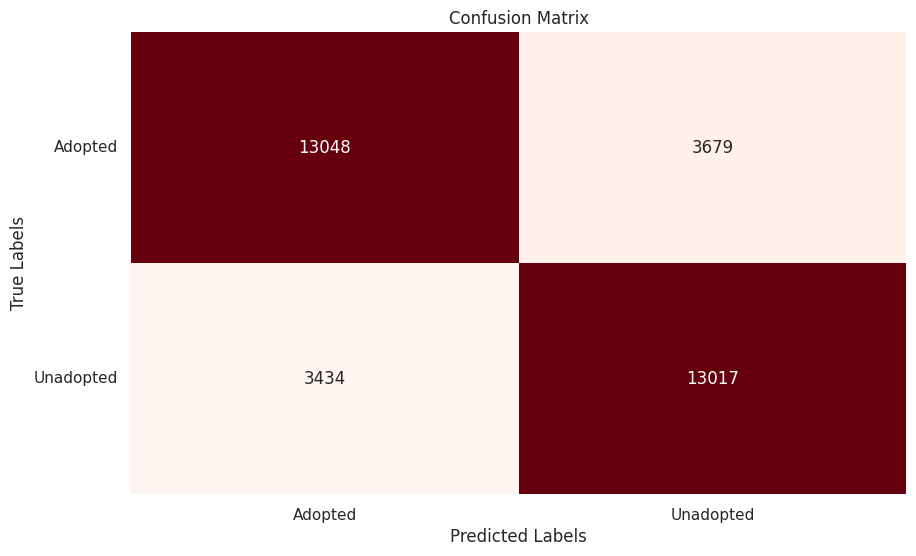

In [ ]:
# code retrieved from: https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap

# plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, cb_predictions)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(10, 6))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Reds', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

class_labels = ['Adopted', 'Unadopted']
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0, va="center")

plt.show()

Actual Class Counts:
{'Adopted': 16727, 'Unadopted': 16451}
Predicted Class Counts:
{'Adopted': 16482, 'Unadopted': 16696}


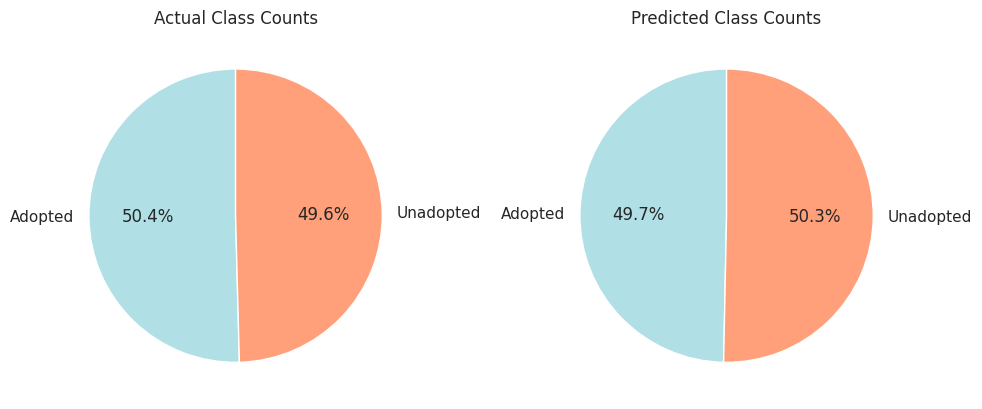

In [ ]:
# visualizing the number of the adoption/no adoption predictions vs the real number

# Actual Class Counts
actual_classes, actual_counts = np.unique(y_test, return_counts=True)
actual_class_counts = dict(zip(['Unadopted' if x == 'Unadopted' else 'Adopted' for x in actual_classes], actual_counts))
print("Actual Class Counts:")
print(actual_class_counts)

# Predicted Class Counts
predicted_classes, predicted_counts = np.unique(cb_predictions, return_counts=True)
predicted_class_counts = dict(zip(['Unadopted' if x == 'Unadopted' else 'Adopted' for x in predicted_classes], predicted_counts))
print("Predicted Class Counts:")
print(predicted_class_counts)


# Visualization with Pie Charts
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Pie chart for Actual class counts
ax[0].pie(actual_counts, labels=actual_class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['powderblue', 'lightsalmon'])
ax[0].set_title('Actual Class Counts')

# Pie chart for Predicted class counts
ax[1].pie(predicted_counts, labels=predicted_class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['powderblue', 'lightsalmon'])
ax[1].set_title('Predicted Class Counts')

plt.tight_layout()
plt.show()